In [1]:
%matplotlib inline

In [2]:
import torch
import random
from d2l import torch as  d2l

生成数据集：
我们根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用有限个样本的数据集来恢复这个模型的参数

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.7576, 0.1993]) 
label: tensor([5.0585])


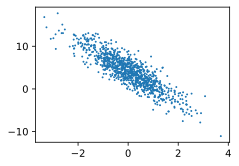

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
def data_iter(batch_size , features , labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0 , num_examples , batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size , num_examples)]
        )
        yield features[batch_indices] , labels[batch_indices]

In [7]:
batch_size = 10
for X,y in data_iter(batch_size , features , labels):
    print(X , '\n' , y)
    break

tensor([[-0.8011, -1.5536],
        [-0.5456,  1.0170],
        [-0.4385,  0.7435],
        [-0.0814,  0.2622],
        [ 0.9943,  0.9551],
        [-1.0396,  1.3464],
        [ 1.2686,  1.0078],
        [ 0.4611,  1.8716],
        [-0.2982, -0.9462],
        [-1.5902,  0.2517]]) 
 tensor([[ 7.8905],
        [-0.3415],
        [ 0.8011],
        [ 3.1458],
        [ 2.9380],
        [-2.4455],
        [ 3.3271],
        [-1.2410],
        [ 6.8045],
        [ 0.1610]])


当我们开始用小批量随机梯度下降的方法优化我们的模型之前，我们需要先有一些参数。在下面的代码中，我们通过从均值为0、
标准差为0.01的正态分布中采用随机数来初始化权重，并将偏置初始化为0

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [10]:
# 损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [11]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042595
epoch 2, loss 0.000175
epoch 3, loss 0.000050


In [13]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-3.4571e-05, -1.4734e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)
